In [1]:
#import block
import numpy as np
from scipy.special import hankel1 as besselh
import scipy.linalg as linalg
from numpy import log, pi, sqrt
import matplotlib.pyplot as plt

In [2]:
#variable block
h = 1
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 0]
m0s = np.array(list(range(1, 101, 1))) * 1e-6
g = 9.81
rho = 1023

In [3]:
#useful constants block
bds = len(a) # number of boundaries

In [4]:
def particular_potential(r, n):
    if n >= bds: # free surface region
        return 0
    if heaving[n]:
        return - (r**2)/(4 * (h - d[n]))
    else:
        return 0

def diff_particular_potential_total(r, n):
    if n >= bds: # free surface region
        return 0
    if heaving[n]:
        return - r/2
    else:
        return 0

def b_potential_entry(n):
    return - particular_potential(a[n], n) + particular_potential(a[n], n + 1)

def b_velocity_entry(n):
    return - diff_particular_potential_total(a[n], n) + diff_particular_potential_total(a[n], n + 1)
    
# sets potential equation for nth boundary into the A matrix
def potential_row(A, n, m0):
    if n == 0:
        if bds == 1: # single cylinder
            A[0][0] = 1
            A[0][1] = - besselh(0, m0 * a[0])
        else:
            A[0][0] = 1
            A[0][1] = - 1
            A[0][2] = - log(a[0])
    elif n == bds - 1:
        A[n][2*n - 1] = 1
        A[n][2*n] = log(a[n])
        A[n][2*n + 1] = - besselh(0, m0 * a[n])
    else:
        A[n][2*n - 1] = 1
        A[n][2*n] = log(a[n])
        A[n][2*n + 1] = - 1
        A[n][2*n + 2] = - log(a[n])

def velocity_row(A, n, m0):
    if n == 0:
        if bds == 1: # single cylinder
            A[bds][0] = 0
            A[bds][1] = h * m0 * besselh(1, m0 * a[0])
        else:
            A[bds][0] = 0
            A[bds][1] = 0
            A[bds][2] = - 1/a[0] * (h - d[1])
    elif n == bds - 1:
        A[bds + n][2*n - 1] = 0
        A[bds + n][2*n] = 1/a[n] * (h - d[n])
        A[bds + n][2*n + 1] = h * m0 * besselh(1, m0 * a[n])
    else:
        A[bds + n][2*n - 1] = 0
        A[bds + n][2*n] = 1/a[n] * (h - d[n])
        A[bds + n][2*n + 1] = 0
        A[bds + n][2*n + 2] = - 1/a[n] * (h - d[n + 1])

def build_A(m0):
    A = np.zeros((2 * bds, 2 * bds), dtype = complex)
    for n in range(bds):
        potential_row(A, n, m0)
        velocity_row(A, n, m0)
    return A

def build_B():
    b1 = (np.vectorize(b_potential_entry, otypes = [float]))(list(range(bds)))
    b2 = (np.vectorize(b_velocity_entry, otypes = [float]))(list(range(bds)))
    return np.concatenate([b1, b2])
    

# modifies A matrix for a particular m0, all other parameters the same.
def A_new_m0(A, m0):
    A[bds-1][2*bds-1] = - besselh(0, m0 * a[-1]) 
    A[2*bds-1][2*bds-1] = h * m0 * besselh(1, m0 * a[-1])
    

In [5]:
# hydro coefficient calculation functions
def particular_potential_int_eval(region, boundary):
    return -(a[boundary]**4)/(16 * (h - d[region]))

def total_particular():
    accumulator = 0
    for region in range(bds):
        if heaving[region]:
            if region == 0:
                accumulator += particular_potential_int_eval(0, 0)
            else:
                accumulator += particular_potential_int_eval(region, region) - particular_potential_int_eval(region, region - 1)
    return accumulator

#dphi/dz mandated to be 1 in the heaving regions, so just integrate potential * r

def ln_potential_int_eval(bd):
    return (a[bd]**2/2) * (log(a[bd]) - 1/2)

def const_potential_int_eval(bd):
    return (a[bd]**2/2)

def create_c_vector():
    c = []
    for region in range(bds):
        if region == 0:
            if heaving[0]:
                c.append(const_potential_int_eval(0))
            else:
                c.append(0)
        else:
            if heaving[region]:
                c.append(const_potential_int_eval(region) - const_potential_int_eval(region - 1))
                c.append(ln_potential_int_eval(region) - ln_potential_int_eval(region - 1))
            else:
                c.append(0)
                c.append(0)
    return c

def get_hydro_coeffs(X, m0):
    const = total_particular()
    c = create_c_vector()
    raw = np.dot(X, c) + const
    total = 2 * pi * rho * raw #* h**3 
    return np.real(total), (np.imag(total)) # * omega_from_m0(m0))

def to_nondim(coeff, a_norm):
    return coeff/(pi * a_norm**3 * rho)

def omega_from_m0(m0): # at small m0 approximation
    return sqrt(m0**2 * h * g)

def get_max_heaving_radius():
    max_rad = a[0]
    for i in range(bds - 1, 0, -1):
        if heaving[i]:
            max_rad = a[i]
            break
    return max_rad

In [6]:
A = build_A(m0s[0])
b = build_B()

solutions = []

for m0 in m0s:
    A_new_m0(A, m0)
    solutions.append(linalg.solve(A,b))

In [7]:
regular_hydros = []
nondim_am = []
nondim_d = []
a_norm = get_max_heaving_radius()
for i in range(len(m0s)):
    added_mass, damping = get_hydro_coeffs(solutions[i][:-1], m0s[i])
    nd_am, nd_d = to_nondim(added_mass, a_norm), to_nondim(damping, a_norm)
    regular_hydros.append((added_mass, damping))
    nondim_am.append(nd_am)
    nondim_d.append(nd_d)

In [8]:
# 2012 solutions for low frequency

a1, a2, d1, d2 = a[0], a[1], d[0], d[1]

# Heaving outer cylinder
def oc_heaving(m0):
    term_1 = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + ((a2**2 - a1**2)/4 + (a1**2/2) * log(a1/a2))/(h-d2)
    beta = term_1 + ((a2**2)/4 - (a1**2/2) * log(a2))/(h-d2)
    gamma = a1**2/(2 * (h-d2))
    delta = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2)/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def oc_heaving_hydros(m0):
    t1 = (a2**2 - a1**2)**2/(2 * h * m0 * a2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    t2 = ((a2**2 - a1**2)**2 + 2 * a1**2 * (a1**2 - a2**2 + 2 * a1**2 * log(a2/a1)))/(8 * (h - d2))
    val = (t1 + t2)/(a2 ** 3)
    return np.real(val), np.imag(val)

# Heaving inner cylinder
def ic_heaving(m0):
    term_1 = (a1**2/(2 * m0 * h * a2)) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + (a1**2 * log(a2/a1))/(2 * (h-d2)) + a1**2/(4 * (h-d1))
    beta = term_1 + (a1**2 * log(a2))/(2 * (h-d2))
    gamma = -a1**2/(2 * (h-d2))
    delta = (a1**2/(2 * m0 * h * a2))/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def ic_heaving_hydros(m0):
    t1 = (besselh(0, m0 * a2))/(h * m0 * a2 * besselh(1, m0 * a2))
    t2 = log(a2/a1)/(h-d2) + 1/(4*(h-d1)) # I think it's an error that (eq. 84) has an 8 instead of a 4 here.
    val = (a1/2) * (t1 + t2)
    return np.real(val), np.imag(val)

# the paper claims these as the limits but I'm not sure                    
oc_heaving_ndr_hydros = -a[1]/(2*h)*(1 - (a[0]/a[1])**2)**2 * log(m0s * a[1])
oc_heaving_ndi_hydros = len(m0s) * [pi * a[1] / (4 * h) * (1 - (a[0]/a[1])**2)**2]
ic_heaving_ndr_hydros = - a[0]/(2*h) * log (m0s * a[1])
ic_heaving_ndi_hydros = pi * a[0] / (4 * h)

oc_coeffs = []
ic_coeffs = []

nondim_am_oc = []
nondim_d_oc = []
nondim_am_ic = []
nondim_d_ic = []

for m0 in m0s:
    nd_oc_am, nd_oc_d = oc_heaving_hydros(m0)
    nondim_am_oc.append(nd_oc_am)
    nondim_d_oc.append(nd_oc_d)
    nd_ic_am, nd_ic_d = ic_heaving_hydros(m0)
    nondim_am_ic.append(nd_ic_am)
    nondim_d_ic.append(nd_ic_d)
    oc_coeffs.append(oc_heaving(m0))
    ic_coeffs.append(ic_heaving(m0))

In [9]:
def coeff_comparisons(lst1, lst2, m0s):
    for i in range(len(m0s)):
        print(m0s[i])
        print(lst1[i])
        print(lst2[i])

#coeff_comparisons(ic_coeffs, solutions, m0s)

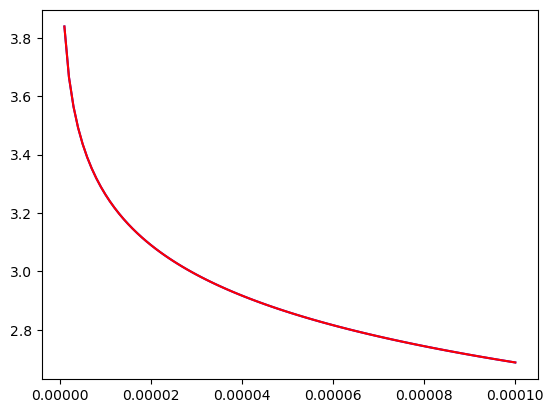

In [10]:
def plot_compare(xs, ys1, ys2):
    plt.plot(xs, ys1, color = "blue")
    plt.plot(xs, ys2, color = "red")
    #plt.plot(xs, ys3, color = "green")
    #plt.plot(xs, np.array(ys1)-np.array(ys2), color = "green")

plot_compare(m0s, nondim_am_ic, nondim_am)


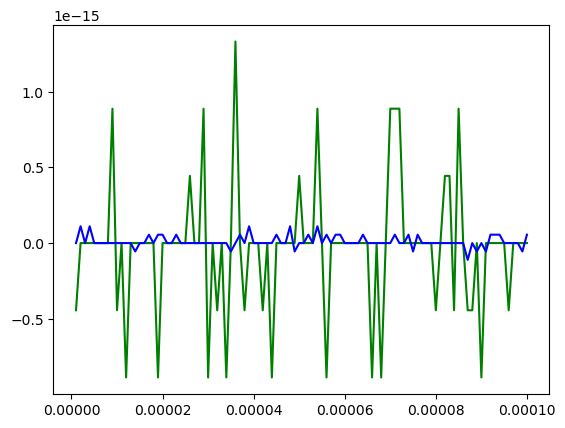

In [11]:
plt.plot(m0s, np.array(nondim_am_ic)-np.array(nondim_am), color = "green")
plt.plot(m0s, np.array(nondim_d)-np.array(nondim_d_ic), color = "blue")

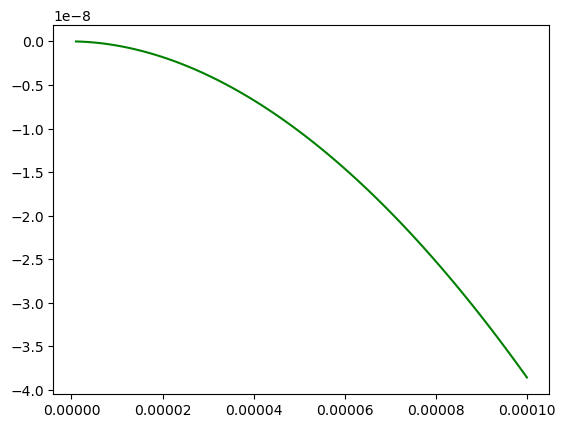

In [12]:
plt.plot(m0s, np.array(nondim_d)-np.array(ic_heaving_ndi_hydros), color = "green")

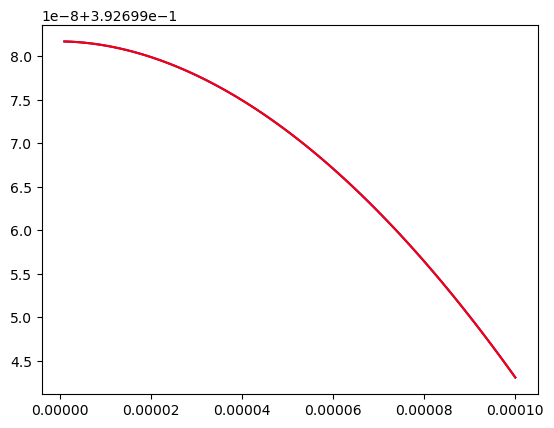

In [13]:
plot_compare(m0s, nondim_d_ic, nondim_d)

In [14]:
def low_solver():
    A = build_A(m0s[0])
    b = build_B()
    solutions = []
    for m0 in m0s:
        A_new_m0(A, m0)
        solutions.append(linalg.solve(A,b))
    
    nondim_am = []
    nondim_d = []
    a_norm = get_max_heaving_radius()
    for i in range(len(m0s)):
        added_mass, damping = get_hydro_coeffs(solutions[i][:-1], m0s[i])
        nd_am, nd_d = to_nondim(added_mass, a_norm), to_nondim(damping, a_norm)
        nondim_am.append(nd_am)
        nondim_d.append(nd_d)
    return nondim_am, nondim_d

added_mass_various = []
damping_various = []

In [20]:
# config0 
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 1]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

1.3640262463216195
2.5292031170945184
3.6799572352241605
4.830112987190839
0.762195003759961
0.7842040565083574
0.7846076466946342
0.7846134727493457


In [19]:
# config1
h = 1.5
d = [1.1, 0.85, 0.75, 0.4, 0.15]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

1.1856963920659827
2.4382407343103165
3.667642581077993
4.895719833223409
0.7875175881343128
0.8367400243252997
0.8377429134078579
0.8377578402971169


In [21]:
# config2
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [1, 1, 1]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

0.029734978422935793
0.13243910771566925
0.24907331248003647
0.3642637997048136
0.039593835603309264
0.0762957198763721
0.0784988260564866
0.0785392254341329


In [22]:
# config3
h = 1.9
d = [0.5, 0.7, 0.8, 0.2, 0.5]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

0.9444870489527376
1.9333378454614216
2.9039182508043244
3.8734529235507056
0.6217244116849838
0.6605842297304997
0.6613759842693614
0.6613877686556185


In [23]:
# config4 
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [0, 1]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

0.7307707149903037
1.3861827048000597
2.0334818962479835
2.68044450672924
0.4287346896149781
0.44111478178595115
0.44134180126573175
0.44134507842150694


In [24]:
# config5
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 0]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

0.9516871489179057
1.5342755843043552
2.1096526433691767
2.6847305193525153
0.3810975018799804
0.3921020282541787
0.39230382334731706
0.3923067363746727


In [25]:
# config6
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1]
m0s = [0.1, 0.01, 0.001, 0.0001]

bds = len(a) # number of boundaries

added_mass, damping = low_solver()
for am in added_mass:
    print(am)
for dmp in damping:
    print(dmp)

0.02295458213957543
0.10800387160688797
0.2045886565722605
0.2999778990430984
0.032787655263100395
0.06318048562962374
0.06500487785737656
0.06503833258200545
